# Libaries

In [1]:
import torch
import torch.nn as nn

import os
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import BertTokenizer
from transformers import AutoTokenizer

import spacy
import timm

from torchvision import transforms

/home/nhatthuong/.miniconda3/envs/env_vqa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
DATASET_ROOT_PATH = '/home/nhatthuong/Documents/ResearchVQA-VQG-firstpaper/VQA/BiLSTM-Resnet/dataset'

In [3]:
df = pd.read_csv(f'{DATASET_ROOT_PATH}/data.csv')
df.head()

,question,answer,image_id
0,what is on the left side of the white oven on ...,garbage_bin,image1
1,what is on the left side of the fire extinguis...,table,image1
2,what is between the the two white and black ga...,chair,image1
3,how many objects are between the fire extingui...,3,image1
4,what is the largest object in this picture,washing_machine,image1


In [4]:
df.describe()

,question,answer,image_id
count,12468,12468,12468
unique,5886,1443,1447
top,what is on the table,2,image8
freq,248,554,31


# Create Dataset

In [5]:
def create_data_sample(path):
    df = pd.read_csv(path)
    
    questions = df['question'].tolist()
    answers = df['answer'].tolist()
    images = df['image_id'].tolist()

    data_sample = []

    for question, answer, image in zip(questions, answers, images):
        answer_choices = answer.split(', ')
        sample = {
            'question': question + "?",
            'answer': answer_choices[0] ,
            'image_id': image
        }
        data_sample.append(sample)

    return data_sample

all_data = create_data_sample(f'{DATASET_ROOT_PATH}/data.csv')
train_data = create_data_sample(f'{DATASET_ROOT_PATH}/data_train.csv')
test_data = create_data_sample(f'{DATASET_ROOT_PATH}/data_eval.csv')

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

vocab = tokenizer.get_vocab()
vocab_size = len(vocab)

print(f"Vocab size: {vocab_size}")
print(list(vocab.keys())[1000:1050])

Vocab size: 30522
['"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']


In [7]:
def tokenize(question, max_seq_len):
    # Sử dụng phương thức encode của tokenizer
    tokens = tokenizer.encode(
        question,
        add_special_tokens=True,  # Thêm [CLS] và [SEP]
        max_length=30,
        padding='max_length',     # Padding đến max_seq_len
        truncation=True           # Cắt bớt nếu quá dài
    )
    return tokens

print(tokenize(all_data[0]['question'], max_seq_len=30))

[101, 2054, 2003, 2006, 1996, 2187, 2217, 1997, 1996, 2317, 17428, 2006, 1996, 2723, 1998, 2006, 2157, 2217, 1997, 1996, 2630, 29372, 1029, 102, 0, 0, 0, 0, 0, 0]


In [8]:
ANSWER_SPACE_PATH = f'{DATASET_ROOT_PATH}/answer_space.txt'
with open(ANSWER_SPACE_PATH, 'r') as f:
    data = f.read()
    classes = data.split('\n')
    n_classes = len(classes)

    classes_to_idx = {
        cls_name: idx for idx, cls_name in enumerate(classes)
    }

    idx_to_classes = {
        idx: cls_name for idx, cls_name in enumerate(classes)
    }

In [9]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        max_seq_len = 30,
        transform = None,
        root_dir = f'{DATASET_ROOT_PATH}/images'
    ):
        self.data = data
        self.classes_to_idx = classes_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform
        self.root_dir = root_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(
            self.root_dir,
            self.data[index]['image_id'] + '.png'
        )
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        question = self.data[index]['question']
        question = tokenize(question, self.max_seq_len)
        question = torch.tensor(question, dtype=torch.long)

        answer = self.data[index]['answer']
        answer = self.classes_to_idx[answer]
        answer = torch.tensor(answer, dtype=torch.long)

        return img, question, answer

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

transform2visual = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = VQADataset(train_data[:int(0.9*len(train_data))], classes_to_idx, transform=transform)
val_dataset = VQADataset(train_data[int(0.9*len(train_data)):], classes_to_idx, transform=transform)
test_dataset = VQADataset(test_data, classes_to_idx, transform=transform)
test_dataset_visual = VQADataset(test_data, classes_to_idx, transform=transform2visual)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
)

test_loader_visual = torch.utils.data.DataLoader(
    test_dataset_visual,
    batch_size=16,
    shuffle=False,
)

In [11]:
print(train_dataset.data)

[{'question': 'what is the object on the shelves?', 'answer': 'cup', 'image_id': 'image100'}, {'question': 'how man chairs are there?', 'answer': '6', 'image_id': 'image888'}, {'question': 'what is hanged to the right side of the bed?', 'answer': 'curtain', 'image_id': 'image1174'}, {'question': 'how many picture are on the wall?', 'answer': '2', 'image_id': 'image942'}, {'question': 'what is the object on the floor behind the rack?', 'answer': 'room_divider', 'image_id': 'image1220'}, {'question': 'what is the object on the floor in front of the cabinet?', 'answer': 'garbage_bin', 'image_id': 'image541'}, {'question': 'what is beneath the stove?', 'answer': 'oven', 'image_id': 'image576'}, {'question': 'what is on the night stand?', 'answer': 'lamp', 'image_id': 'image1013'}, {'question': 'what is on the above the stove?', 'answer': 'microwave', 'image_id': 'image867'}, {'question': 'what is on the wall?', 'answer': 'spot_light', 'image_id': 'image1070'}, {'question': 'what is above t

# Create Model ResNet + BiLSTM

In [12]:
class VQAModel(nn.Module):
    def __init__(
        self,
        vocab_size,
        img_model_name='resnet50',
        embedding_dim=256,  # Cập nhật kích thước embedding
        n_layers=1,
        hidden_size=128,
        dropout_prob=0.2,
        max_answer_length=20  # Maximum length of the answer
    ):
        super(VQAModel, self).__init__()
        self.image_encoder = timm.create_model(
            img_model_name,
            pretrained=True,
            num_classes=hidden_size
        )

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.bilstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )

        # BiLSTM cho phần giải mã
        self.bilstm_decoder = nn.LSTM(
            input_size=hidden_size * 2,  
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=False
        )

        self.dropout = nn.Dropout(dropout_prob)

        # Fully connected layer để tạo ra câu trả lời
        self.fc = nn.Linear(hidden_size, vocab_size)

        self.max_answer_length = max_answer_length  # Độ dài tối đa của câu trả lời

    def forward(self, img, text, answer_input=None):
        img_features = self.image_encoder(img)

        text_emb = self.embedding(text)
        bilstm_out, _ = self.bilstm1(text_emb)

        # Lấy đầu ra của BiLSTM
        lstm_out = bilstm_out[:, -1, :]

        # Kết hợp đặc trưng hình ảnh và đầu ra của BiLSTM
        combined = torch.cat((img_features, lstm_out), dim=1)

        # Nếu answer_input là None, sử dụng token bắt đầu để bắt đầu quá trình giải mã
        if answer_input is None:
            answer_input = torch.zeros((img.size(0), self.max_answer_length), dtype=torch.long).to(img.device)

        # Nhận embedding cho đầu vào của decoder
        decoder_emb = self.embedding(answer_input)

        # Khởi tạo trạng thái ẩn cho decoder
        hidden = None
        outputs = []

        for t in range(self.max_answer_length):
            # Chạy qua BiLSTM giải mã
            decoder_out, hidden = self.bilstm_decoder(decoder_emb, hidden)

            # Áp dụng dropout và fully connected layer để tạo ra đầu ra
            decoder_out = self.dropout(decoder_out)
            output = self.fc(decoder_out)

            # Lưu trữ đầu ra cho mỗi bước
            outputs.append(output)

            # Sử dụng token có xác suất cao nhất để làm đầu vào cho bước tiếp theo (greedy decoding)
            if t < self.max_answer_length - 1:  # Đảm bảo không vượt quá max_answer_length
                decoder_emb = self.embedding(torch.argmax(output[:, -1, :], dim=1)).unsqueeze(1)

        # Chuyển đổi đầu ra thành tensor
        # Kích thước của outputs sẽ là [max_answer_length, batch_size, vocab_size]
        return torch.cat(outputs, dim=1)  # Shape: (batch_size, max_answer_length, vocab_size)

# Khởi tạo các tham số
img_model_name = 'resnet50'
hidden_size = 128
n_layers = 1
embedding_dim = 256  # Kích thước embedding phải tương ứng
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_answer_length = 20  # Độ dài tối đa của câu trả lời

# Khởi tạo mô hình
model = VQAModel(
    vocab_size,
    img_model_name=img_model_name,
    embedding_dim=embedding_dim,
    n_layers=n_layers,
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    max_answer_length=max_answer_length
).to(device)

# Kiểm tra cấu trúc của mô hình
print(model)

images, questions, labels = next(iter(train_loader))

model.eval()
with torch.no_grad():
    images = images.to(device)
    questions = questions.to(device)
    output = model(images, questions)
    print(output.shape) 


VQAModel(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-0

# Training

In [13]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for image, question, labels in dataloader:
            image, question, labels = image.to(device), question.to(device), labels.to(device)
            outputs = model(image, question)
            
            # Chọn đầu ra cuối cùng để tính toán mất mát
            outputs_last = outputs[:, -1, :]  # Chọn đầu ra cuối cùng
            
            # Tính toán mất mát giữa đầu ra cuối và nhãn
            loss = criterion(outputs_last, labels)
            losses.append(loss.item())
            
            # Dự đoán nhãn từ đầu ra cuối cùng
            _, predicted = torch.max(outputs_last.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [14]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (images, questions, labels) in enumerate(train_loader):
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)

            # Sử dụng đầu ra cuối cùng để tính toán mất mát
            # Chọn đầu ra cuối cùng từ outputs, có kích thước [batch_size, vocab_size]
            outputs_last = outputs[:, -1, :]  # Chọn đầu ra cuối cùng

            loss = criterion(outputs_last, labels)  # So sánh với labels
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses


In [15]:
lr = 1e-3 
epochs = 50

scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 5.9372	Val loss: 5.0977	Val Acc: 0.04909819639278557
EPOCH 2:	Train loss: 5.0934	Val loss: 5.0531	Val Acc: 0.04909819639278557
EPOCH 3:	Train loss: 5.0439	Val loss: 5.0511	Val Acc: 0.04909819639278557
EPOCH 4:	Train loss: 5.0282	Val loss: 5.0519	Val Acc: 0.04909819639278557


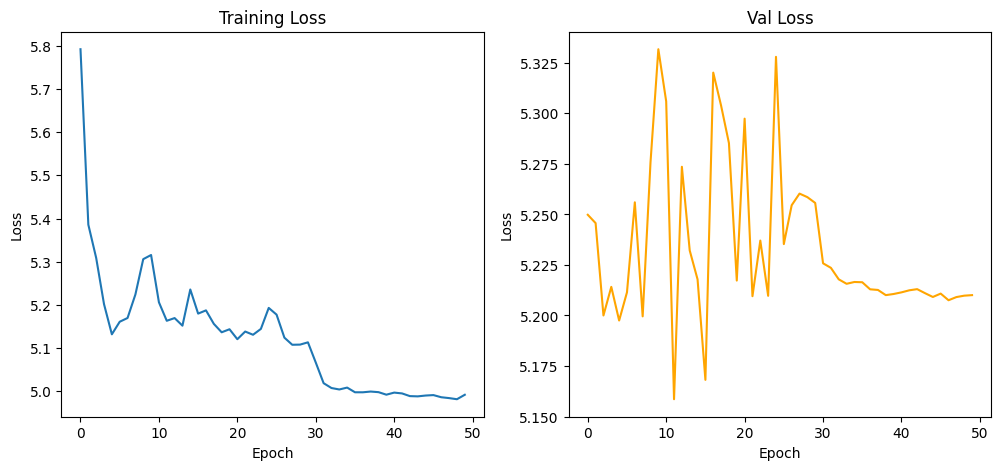

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# Evaluation

In [17]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.04909819639278557
Test accuracy:  0.04490777866880513
